# Lending club case study

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("./loan.csv", low_memory=False)
df.shape

(39717, 111)

## Handle missing values in the data

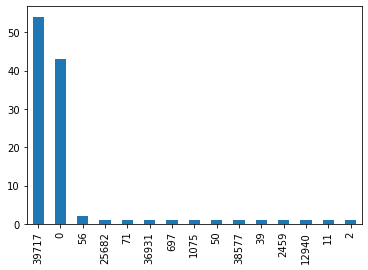

In [3]:
dfnull = pd.DataFrame()
dfnull['nans'] = df.isnull().sum()
dfnull['nans'].value_counts().plot.bar()

### 54 columns have 39717 'nans' - same as the number of rows. Drop these columns.

In [4]:
df = df.dropna(axis=1, how='all')
df.shape

(39717, 57)

## Columns with same values - these are not useful for analysis

In [5]:
same_columns = {}
for c in df.columns:
    if df[c].value_counts().shape[0] == 1:
        same_columns[c] = list(df[c].unique())
same_columns

{'pymnt_plan': ['n'],
 'initial_list_status': ['f'],
 'collections_12_mths_ex_med': [0.0, nan],
 'policy_code': [1],
 'application_type': ['INDIVIDUAL'],
 'acc_now_delinq': [0],
 'chargeoff_within_12_mths': [0.0, nan],
 'delinq_amnt': [0],
 'tax_liens': [0.0, nan]}

### Drop columns with same values

In [6]:
df = df.drop(same_columns.keys(), axis=1)
df.shape

(39717, 48)

In [7]:
# Check null values again
df[df.columns[df.isnull().any()]].isnull().sum()

emp_title                  2459
emp_length                 1075
desc                      12940
title                        11
mths_since_last_delinq    25682
mths_since_last_record    36931
revol_util                   50
last_pymnt_d                 71
next_pymnt_d              38577
last_credit_pull_d            2
pub_rec_bankruptcies        697
dtype: int64

### Columns with more than 50% missing values

In [8]:
too_many_nans = df[df.columns[df.isnull().sum() * 100 / df.shape[0] > 50]].columns.tolist()
too_many_nans

['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d']

In [9]:
df = df.drop(too_many_nans, axis=1)
df.shape

(39717, 45)

In [10]:
df[df.columns[df.isnull().any()]].isnull().sum()

emp_title                2459
emp_length               1075
desc                    12940
title                      11
revol_util                 50
last_pymnt_d               71
last_credit_pull_d          2
pub_rec_bankruptcies      697
dtype: int64

### Check columns one by one

In [11]:
df.desc.describe()

count     26777
unique    26527
top            
freq        210
Name: desc, dtype: object

In [12]:
df.desc.head()

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                  NaN
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object

### employe title

In [13]:
df.emp_title.value_counts()

US Army              134
Bank of America      109
IBM                   66
AT&T                  59
Kaiser Permanente     56
                    ... 
general dynamics       1
MGA Entertainment      1
RAM DME                1
john's painting        1
Kalypso                1
Name: emp_title, Length: 28820, dtype: int64

#### Can drop 'emp_title' and 'desc' - they seem to have too many values to analyze for now

In [14]:
df.emp_length.value_counts()

10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: emp_length, dtype: int64

### Impute emp_length

In [15]:
import re
df.emp_length = df.emp_length.fillna('unknown')
df.emp_length.value_counts()

10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
unknown      1075
Name: emp_length, dtype: int64

### handle 'title'

In [16]:
df.title.value_counts()

Debt Consolidation              2184
Debt Consolidation Loan         1729
Personal Loan                    659
Consolidation                    517
debt consolidation               505
                                ... 
New Business Website Launch        1
Pay Off Credit Cards Finally       1
cc refinance loan                  1
Me                                 1
basement repair                    1
Name: title, Length: 19615, dtype: int64

In [17]:
len(df.title.unique().tolist())

19616

In [18]:
df.title = df.title.fillna('unknown')
len(df.title.unique().tolist())

19616

#### Can drop 'title' 
It has 19k unique values.  
Ideally it may be possible to consolidate these, into broad categories like 'debt consolodation', 'credit card' etc.  
Skipping for now.

In [19]:
df = df.drop(['title', 'desc', 'emp_title'], axis=1)
df.shape

(39717, 42)

### Inspect some more data

In [20]:
df.revol_util.value_counts()

0%        977
0.20%      63
63%        62
40.70%     58
66.70%     58
         ... 
2.64%       1
1.88%       1
5.79%       1
77.63%      1
4.85%       1
Name: revol_util, Length: 1089, dtype: int64

In [21]:
df.last_pymnt_d.value_counts()

May-16    1256
Mar-13    1026
Dec-14     945
May-13     907
Feb-13     869
          ... 
Jun-08      10
Nov-08      10
Mar-08       5
Jan-08       4
Feb-08       1
Name: last_pymnt_d, Length: 101, dtype: int64

### dropping nans for 'last_pymnt_d', 'revol_util', 'last_credit_pull_d'
#### We loose very little data

In [22]:
# dropping nans for 'last_pymnt_d', 'revol_util', 'last_credit_pull_d'
# We loose very little data
df1 = df[df['last_pymnt_d'].notna()]
df1 = df1[df1['revol_util'].notna()]
df1 = df1[df1['last_credit_pull_d'].notna()]
100 - df1.shape[0] / df.shape[0] * 100

0.29961981015685524

#### final data lost is only 0.30%

### handle pub_rec_bankruptcies

In [23]:
df1.pub_rec_bankruptcies.value_counts()

0.0    37228
1.0     1667
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [24]:
df1.pub_rec_bankruptcies.dtype

dtype('float64')

#### Fill nans with mode 0.0

In [25]:
df1.pub_rec_bankruptcies = df1.pub_rec_bankruptcies.fillna(df1.pub_rec_bankruptcies.mode(dropna=True)[0])

In [26]:
df1[df1.columns[df1.isnull().any()]].isnull().sum()

Series([], dtype: float64)

In [27]:
df1.shape

(39598, 42)

## This Ends handling all missing values in the data
---

### loan_status is our target variable

Fully Paid     32915
Charged Off     5543
Current         1140
Name: loan_status, dtype: int64


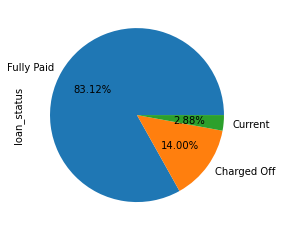

In [28]:
df1['loan_status'].value_counts().plot(kind='pie', autopct='%1.2f%%') # figsize=(15,10)
print(df1['loan_status'].value_counts())
plt.show()

In [29]:
# check remaining columns
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39598 entries, 0 to 39716
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39598 non-null  int64  
 1   member_id                39598 non-null  int64  
 2   loan_amnt                39598 non-null  int64  
 3   funded_amnt              39598 non-null  int64  
 4   funded_amnt_inv          39598 non-null  float64
 5   term                     39598 non-null  object 
 6   int_rate                 39598 non-null  object 
 7   installment              39598 non-null  float64
 8   grade                    39598 non-null  object 
 9   sub_grade                39598 non-null  object 
 10  emp_length               39598 non-null  object 
 11  home_ownership           39598 non-null  object 
 12  annual_inc               39598 non-null  float64
 13  verification_status      39598 non-null  object 
 14  issue_d               

#### drop un-necessary columns
- url - only a link. Will not be useful
- recoveries - we want to see which loan will default - so anything after default is not useful
- id, member_id - only ids, not useful
- collection_recovery_fee - post charge-off

In [30]:
cols_to_drop = ['id', 'member_id', 'url', 'recoveries', 'collection_recovery_fee']
df1 = df1.drop(cols_to_drop, axis=1)
df1.shape

(39598, 37)

### Clean data

In [31]:
df1.term.value_counts().index

Index([' 36 months', ' 60 months'], dtype='object')

In [32]:
df1.term = df1.term.apply(lambda x: x.strip())
df1.term.value_counts().index

Index(['36 months', '60 months'], dtype='object')

#### convert % to float

In [33]:
# Data cleaning convert % to float 
for col in ['int_rate', 'revol_util']:
    df1[col] = df1[col].str.rstrip('%')
    df1[col] = df1[col].astype(np.float64)
    print(df1[col].dtype, col)

float64 int_rate
float64 revol_util


### Handle dates

In [34]:
# Check date format
date_cols = ['issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line']
for col in date_cols:
    print(df1[col].value_counts().index[0:5])

Index(['Dec-11', 'Nov-11', 'Oct-11', 'Sep-11', 'Aug-11'], dtype='object')
Index(['May-16', 'Mar-13', 'Dec-14', 'May-13', 'Feb-13'], dtype='object')
Index(['May-16', 'Apr-16', 'Mar-16', 'Feb-13', 'Feb-16'], dtype='object')
Index(['Nov-98', 'Oct-99', 'Dec-98', 'Oct-00', 'Dec-97'], dtype='object')


In [35]:
# Convert to datetime
for col in date_cols:
    df1[col] = pd.to_datetime(df1[col], format='%b-%y')
    print(df1[col].dtype, col)

datetime64[ns] issue_d
datetime64[ns] last_pymnt_d
datetime64[ns] last_credit_pull_d
datetime64[ns] earliest_cr_line


In [36]:
df1.dtypes

loan_amnt                        int64
funded_amnt                      int64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                 datetime64[ns]
loan_status                     object
purpose                         object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                      int64
earliest_cr_line        datetime64[ns]
inq_last_6mths                   int64
open_acc                         int64
pub_rec                          int64
revol_bal                        int64
revol_util                     float64
total_acc                

In [37]:
df1.shape

(39598, 37)

### Make annual_inc more readable

In [38]:
# Make annual_inc more readable
df1.annual_inc = df1.annual_inc / 1000
df1.annual_inc.describe()

count    39598.000000
mean        69.035085
std         63.828578
min          4.000000
25%         40.632500
50%         59.000000
75%         82.500000
max       6000.000000
Name: annual_inc, dtype: float64

## Start Univariate Analysis

In [39]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,39598.0,11232.584979,7455.138187,500.00,5500.000000,10000.000000,15000.000000,35000.00000
funded_amnt,39598.0,10960.037754,7185.306577,500.00,5400.000000,9700.000000,15000.000000,35000.00000
funded_amnt_inv,39598.0,10411.715905,7128.162229,0.00,5000.000000,8975.000000,14400.000000,35000.00000
int_rate,39598.0,12.013703,3.724028,5.42,9.250000,11.830000,14.540000,24.59000
installment,39598.0,324.888553,208.826448,15.69,167.275000,280.800000,430.947500,1305.19000
annual_inc,39598.0,69.035085,63.828578,4.00,40.632500,59.000000,82.500000,6000.00000
dti,39598.0,13.321031,6.675882,0.00,8.190000,13.410000,18.600000,29.99000
delinq_2yrs,39598.0,0.146295,0.490985,0.00,0.000000,0.000000,0.000000,11.00000
inq_last_6mths,39598.0,0.868554,1.070026,0.00,0.000000,1.000000,1.000000,8.00000
open_acc,39598.0,9.303727,4.399162,2.00,6.000000,9.000000,12.000000,44.00000


In [40]:
df_num = df1.select_dtypes(include = ['float64', 'int64'])
df_num.shape

(39598, 23)

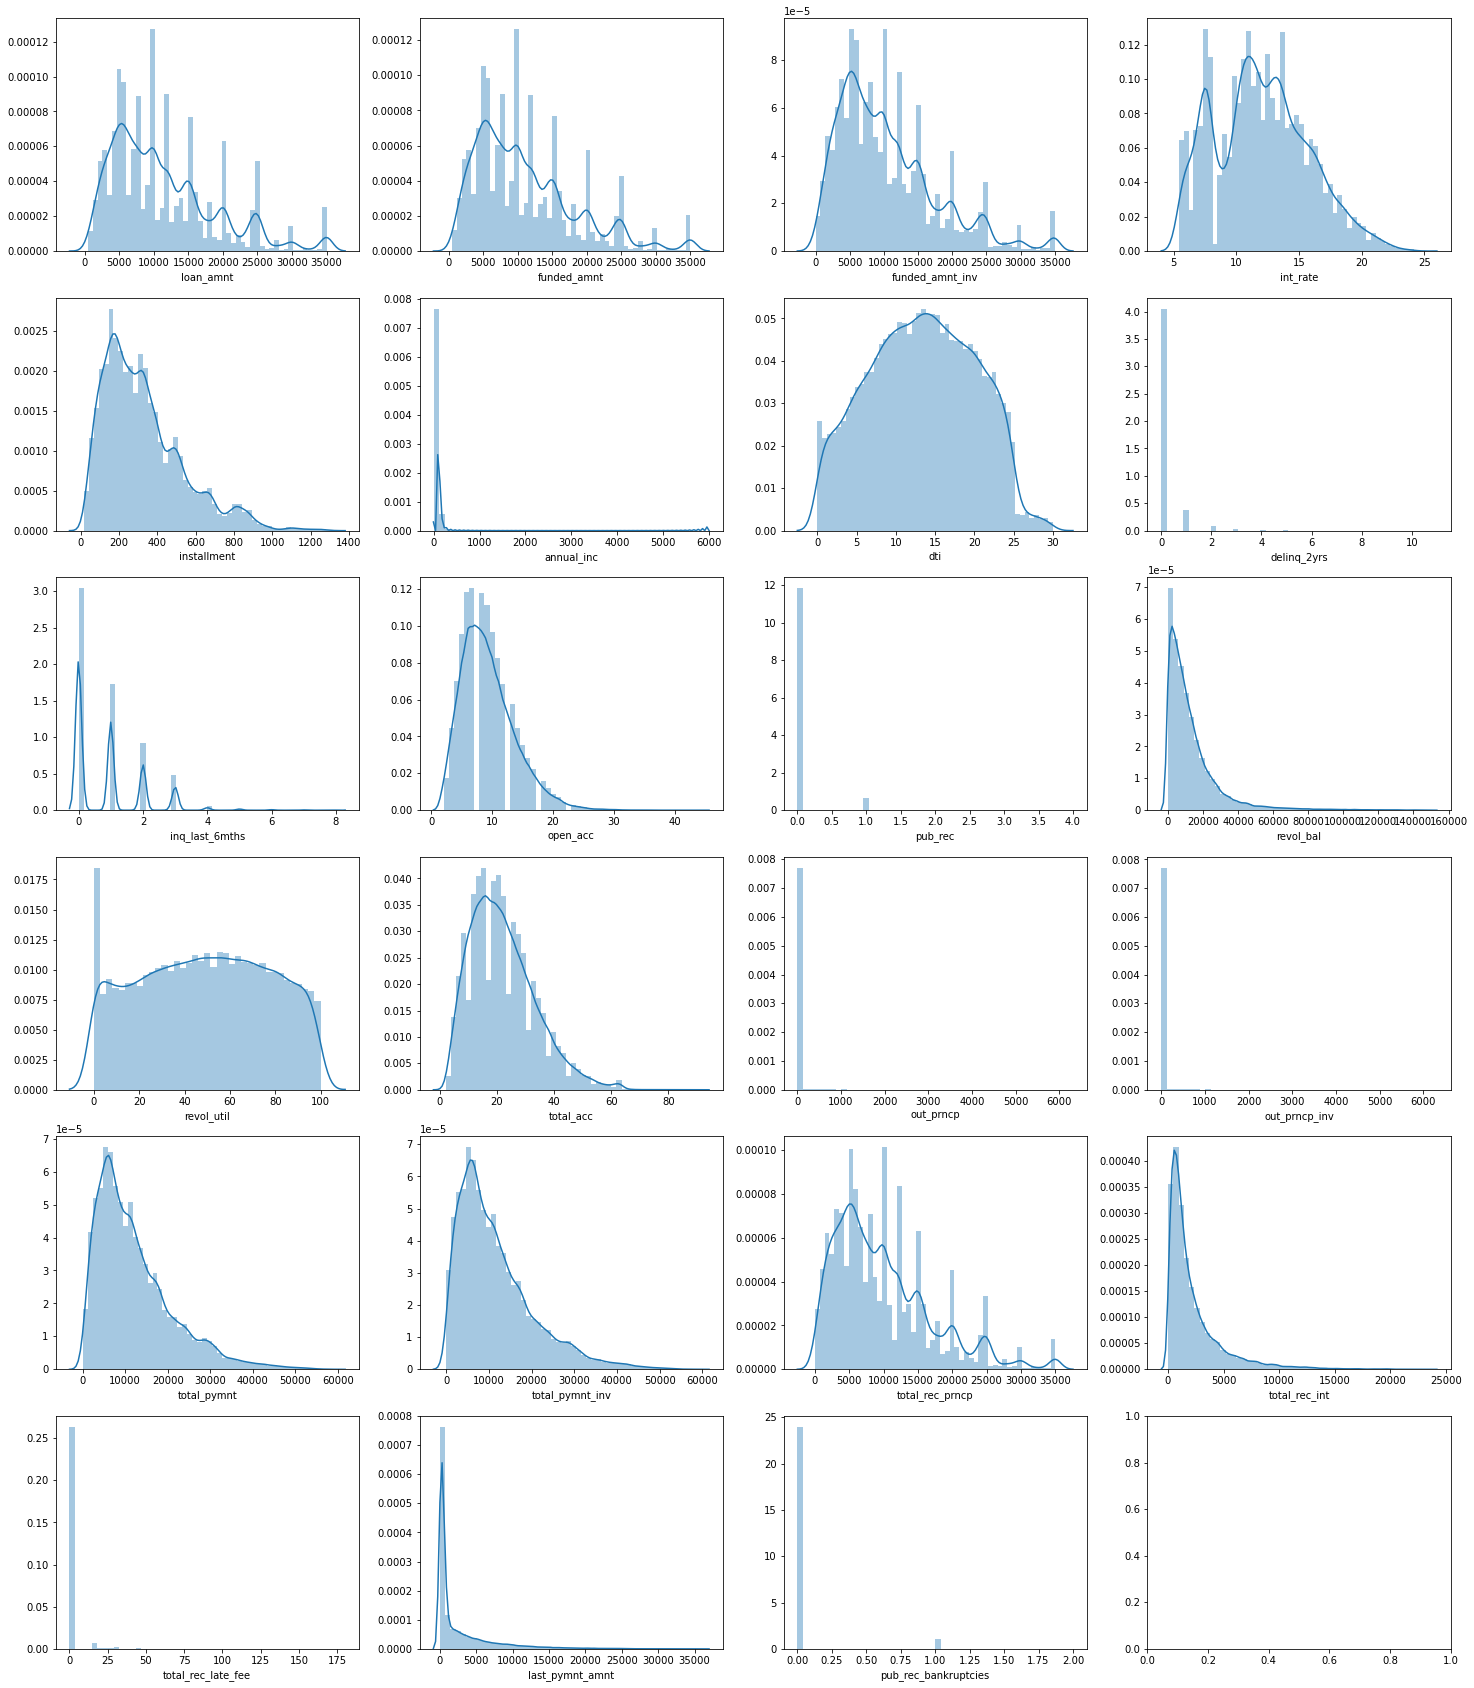

In [41]:
import warnings
warnings.filterwarnings("ignore")
fig1, axes = plt.subplots(nrows= 6, ncols = 4, figsize=(25, 30))
for i, c in enumerate(df_num.columns):
#     print(i, i // 5, i % 5,  c)
    sns.distplot(df_num[c], hist=True, ax=axes[i // 4, i % 4])
plt.show()

### Some features seem to have huge number of same values

In [42]:
for c in ['total_rec_late_fee', 'out_prncp_inv', 'out_prncp', 
          'pub_rec_bankruptcies', 'pub_rec', 'delinq_2yrs']:
    print(f'{df1[c].value_counts()[0] / df1.shape[0] * 100:.4f}, {len(df1[c].unique().tolist())}, {c}')

94.8482, 1353, total_rec_late_fee
97.1211, 1138, out_prncp_inv
97.1211, 1137, out_prncp
95.7725, 3, pub_rec_bankruptcies
94.6790, 5, pub_rec
89.1459, 11, delinq_2yrs


#### Drop the above features

In [43]:
too_many_same_values = ['total_rec_late_fee', 'out_prncp_inv', 'out_prncp']
df1 = df1.drop(too_many_same_values, axis=1)
df1.shape

(39598, 34)

#### Total payment and total recovery cannot help in predicting default. Drop these features.

In [44]:
bad_data = ['total_pymnt','total_pymnt_inv','total_rec_int', 'total_rec_prncp', 
            'funded_amnt', 'funded_amnt_inv']
df1 = df1.drop(bad_data, axis=1)
df1.shape

(39598, 28)

In [45]:
dff64 = df1.select_dtypes(include = ['float64', 'int64'])
dff64.shape

(39598, 14)

#### Find columns with fewer than 15 unique values - these will be treated as categorical

In [46]:
quant_as_catagorical = []
for c in dff64.columns:
    if len(df1[c].unique().tolist()) < 15:
        print(len(df1[c].unique().tolist()), c)
        quant_as_catagorical.append(c)

11 delinq_2yrs
9 inq_last_6mths
5 pub_rec
3 pub_rec_bankruptcies


In [47]:
quant_as_catagorical

['delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'pub_rec_bankruptcies']

#### annual_inc will be analysed later. Final quant features will be:

In [48]:
quant_as_catagorical.append('annual_inc')
quant_columns = list(set(dff64.columns) - set(quant_as_catagorical))
quant_columns

['open_acc',
 'int_rate',
 'total_acc',
 'revol_bal',
 'revol_util',
 'last_pymnt_amnt',
 'dti',
 'installment',
 'loan_amnt']

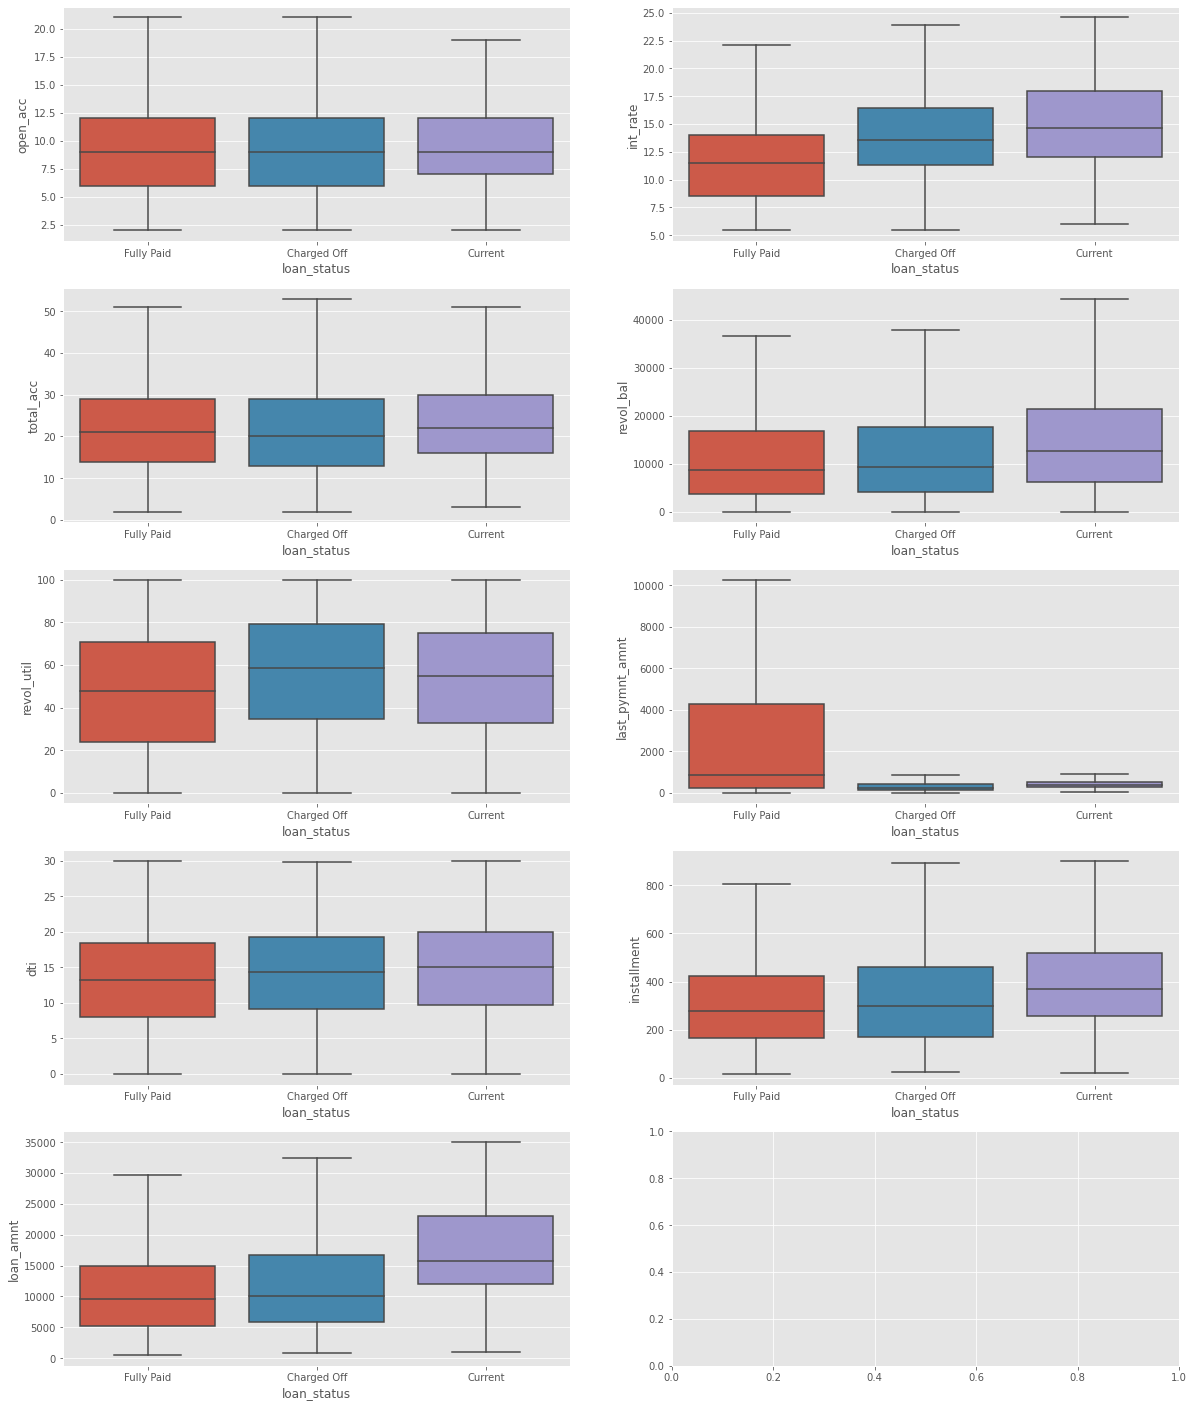

In [49]:
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize=(20, 25))
for i,col in enumerate(quant_columns):
    sns.boxplot(df1.loan_status, df1[col], ax=axes[i//2, i%2], showfliers=False)
plt.show()

### Observations
- int_rate and revol_util seem to be only two variables really impacting default.
- loan_amnt seems to have a slight impact. higher loans mean higher default.

#### Reduce categories in columns with many zeros for easy interpretation

In [50]:
# Reduce categories in columns with many zeros for easy interpretation
df1['pub_rec_bin'] = df1.pub_rec.apply(lambda x: 0 if x == 0 else 1)
df1['delinq_2yrs_bin'] = df1.delinq_2yrs.apply(
    lambda x: 0 if x == 0 else ( 1 if x in [1,2,3,4,5,6] else 2))
df1['inq_last_6mths_bin'] = df1.inq_last_6mths.apply(lambda x: 0 if x == 0 else 1)

#### Plot columns treated as categorical

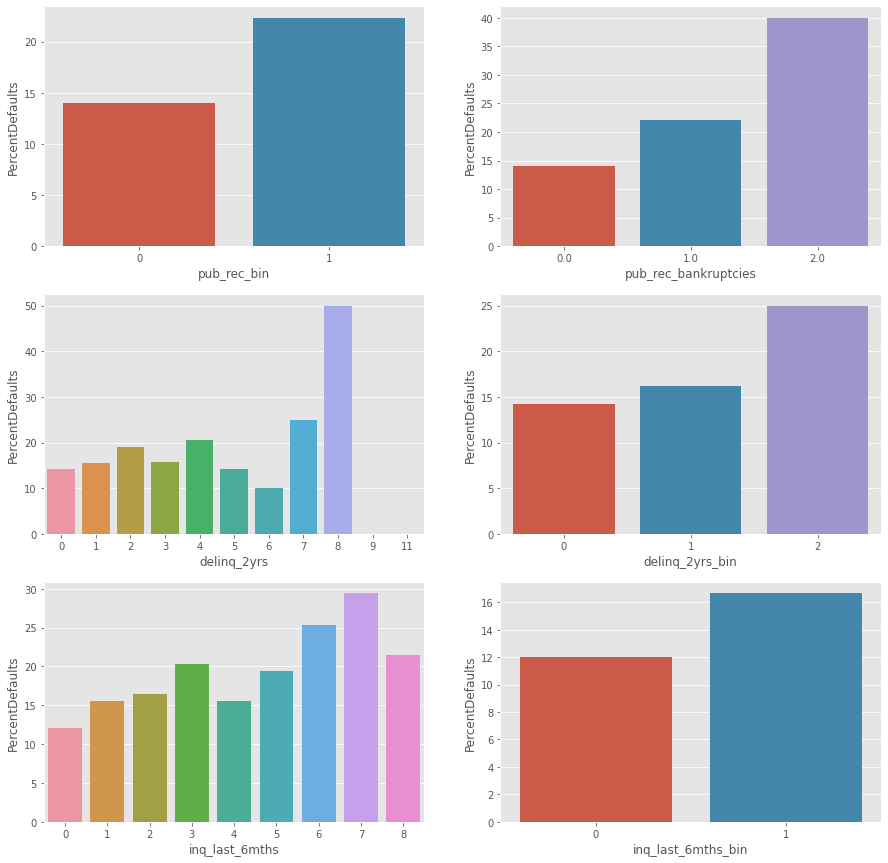

In [51]:
# Plot columns treated as categorical
fig2, axes2 = plt.subplots(nrows=3, ncols = 2, figsize=(15, 15))
for i, col in enumerate(['pub_rec_bin', 'pub_rec_bankruptcies', 'delinq_2yrs', 
                         'delinq_2yrs_bin', 'inq_last_6mths', 'inq_last_6mths_bin']):  
    df2 = pd.pivot_table(data=df1, index=col, columns=['loan_status'], 
                         aggfunc='count', fill_value=0).loan_amnt
    df2['PercentDefaults'] = \
        df2['Charged Off'] / (df2['Fully Paid'] + df2['Charged Off']) * 100
    sns.barplot(df2.index, df2.PercentDefaults, ax=axes2[i//2, i%2])
plt.show()
    

### Observations
- All variables treated as categorical seem to have direct impact on defaults.
- 'pub_rec_bankruptcies' have only 3 distinct values 
- 'pub_rec_bin', 'delinq_2yrs', 'inq_last_6mths' were converted to fewer categories to make analysis easier 

In [52]:
df1.shape

(39598, 31)

## Analyse Categoricals

#### Select only categorical features

In [53]:
dfcat = df1.select_dtypes(exclude = ['float64', 'int64', 'datetime64'] )
dfcat.shape

(39598, 10)

#### Inspect some categorical features

In [54]:
df1.grade.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [55]:
df1.sub_grade.unique()

array(['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
       'A1', 'B3', 'B4', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3', 'C2',
       'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
       'F5', 'G5'], dtype=object)

#### Sub grade seems finer level of grade - we will analyze only grade

In [56]:
df1.drop(['sub_grade'], axis=1)
df1.shape

(39598, 31)

#### Convert grades to integers

In [57]:
grades = {'A': 70, 'B': 60, 'C': 50, 'D': 40, 'E': 30, 'F': 20, 'G': 10 }
df1['grades_int'] = df1.grade.apply(lambda x: int(grades[x]))
print(df1['grades_int'].value_counts())

60    12004
70    10078
50     8059
40     5278
30     2824
20     1043
10      312
Name: grades_int, dtype: int64


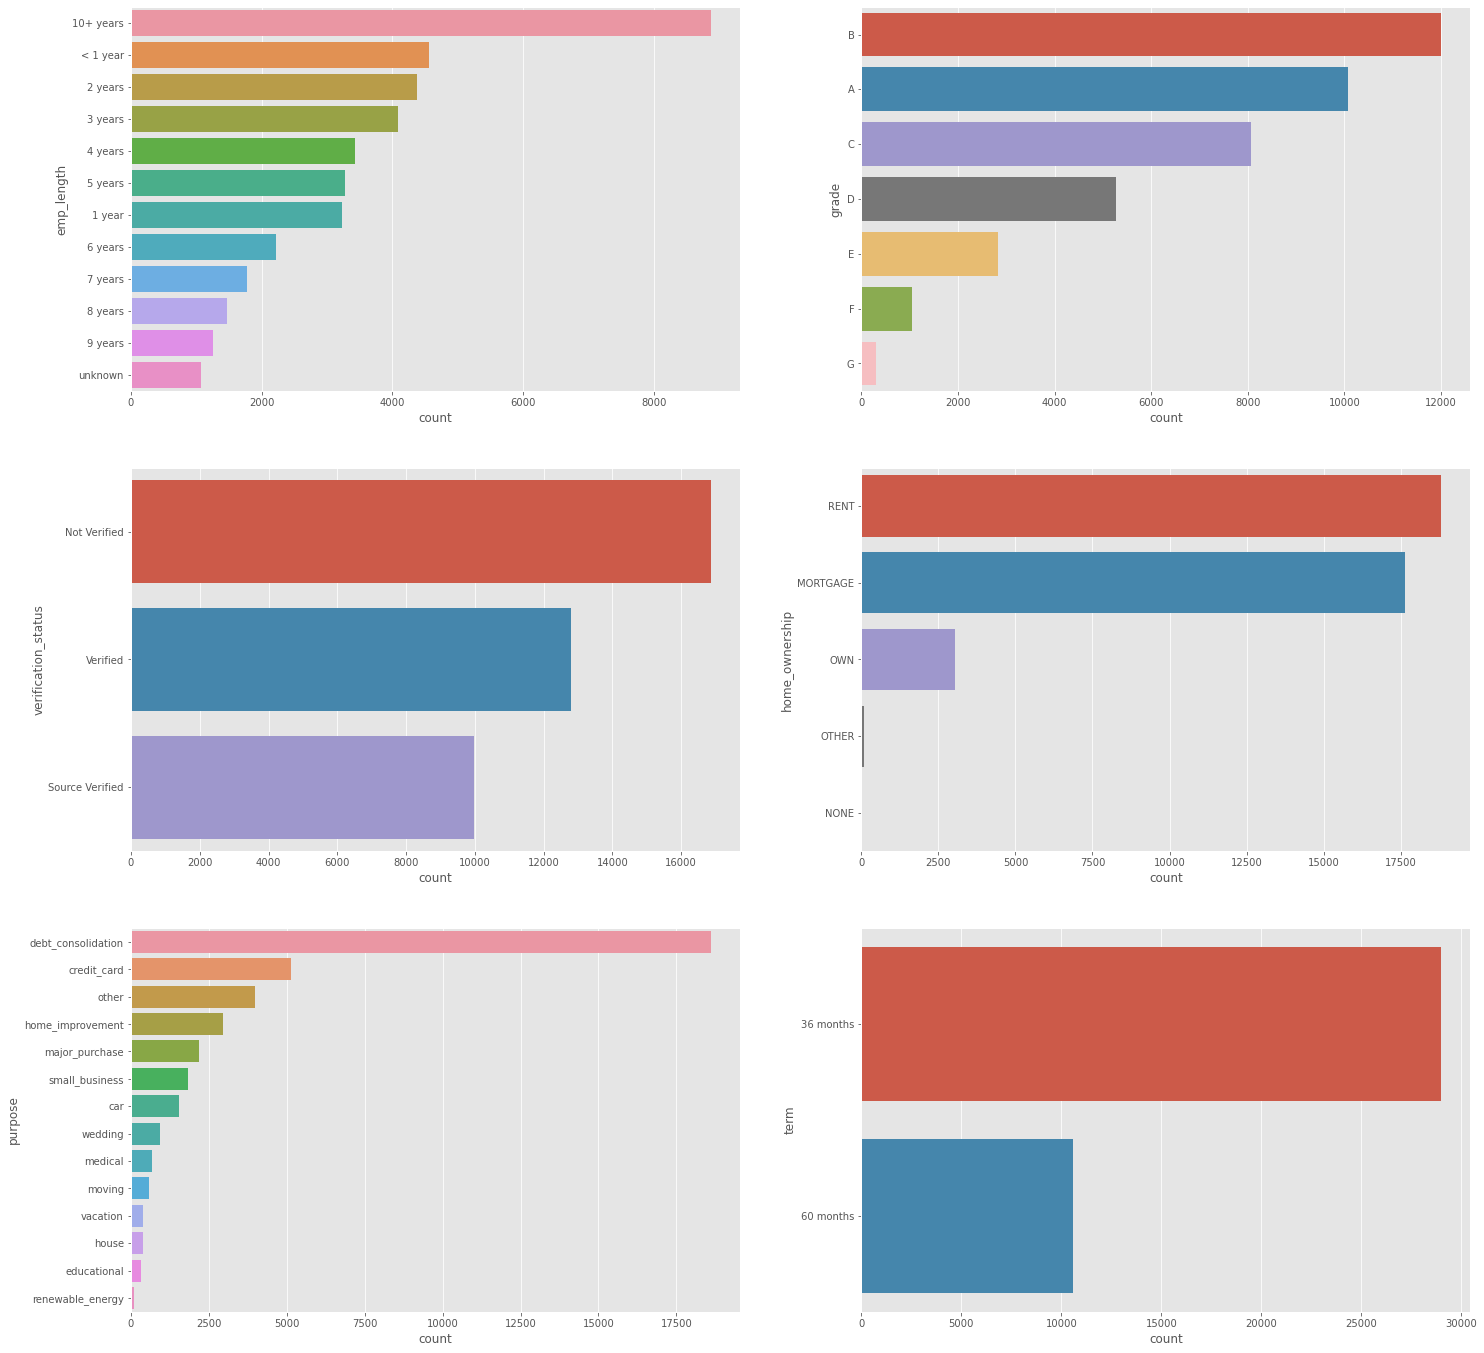

In [58]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(24, 24))
plot_cols = list(set(dfcat.columns) - set(['zip_code', 'addr_state', 'loan_status', 'sub_grade']))
for i, col in enumerate(plot_cols):
    try:
        sns.countplot(y=dfcat[col],
                  order = dfcat[col].value_counts().index, 
                  ax=axes[i // 2, i % 2])
    except:
        print(f'Exception in {col}')
plt.show()

#### Inspect effect of category levels on loan defaults

In [59]:
plot_cols

['emp_length',
 'grade',
 'verification_status',
 'home_ownership',
 'purpose',
 'term']

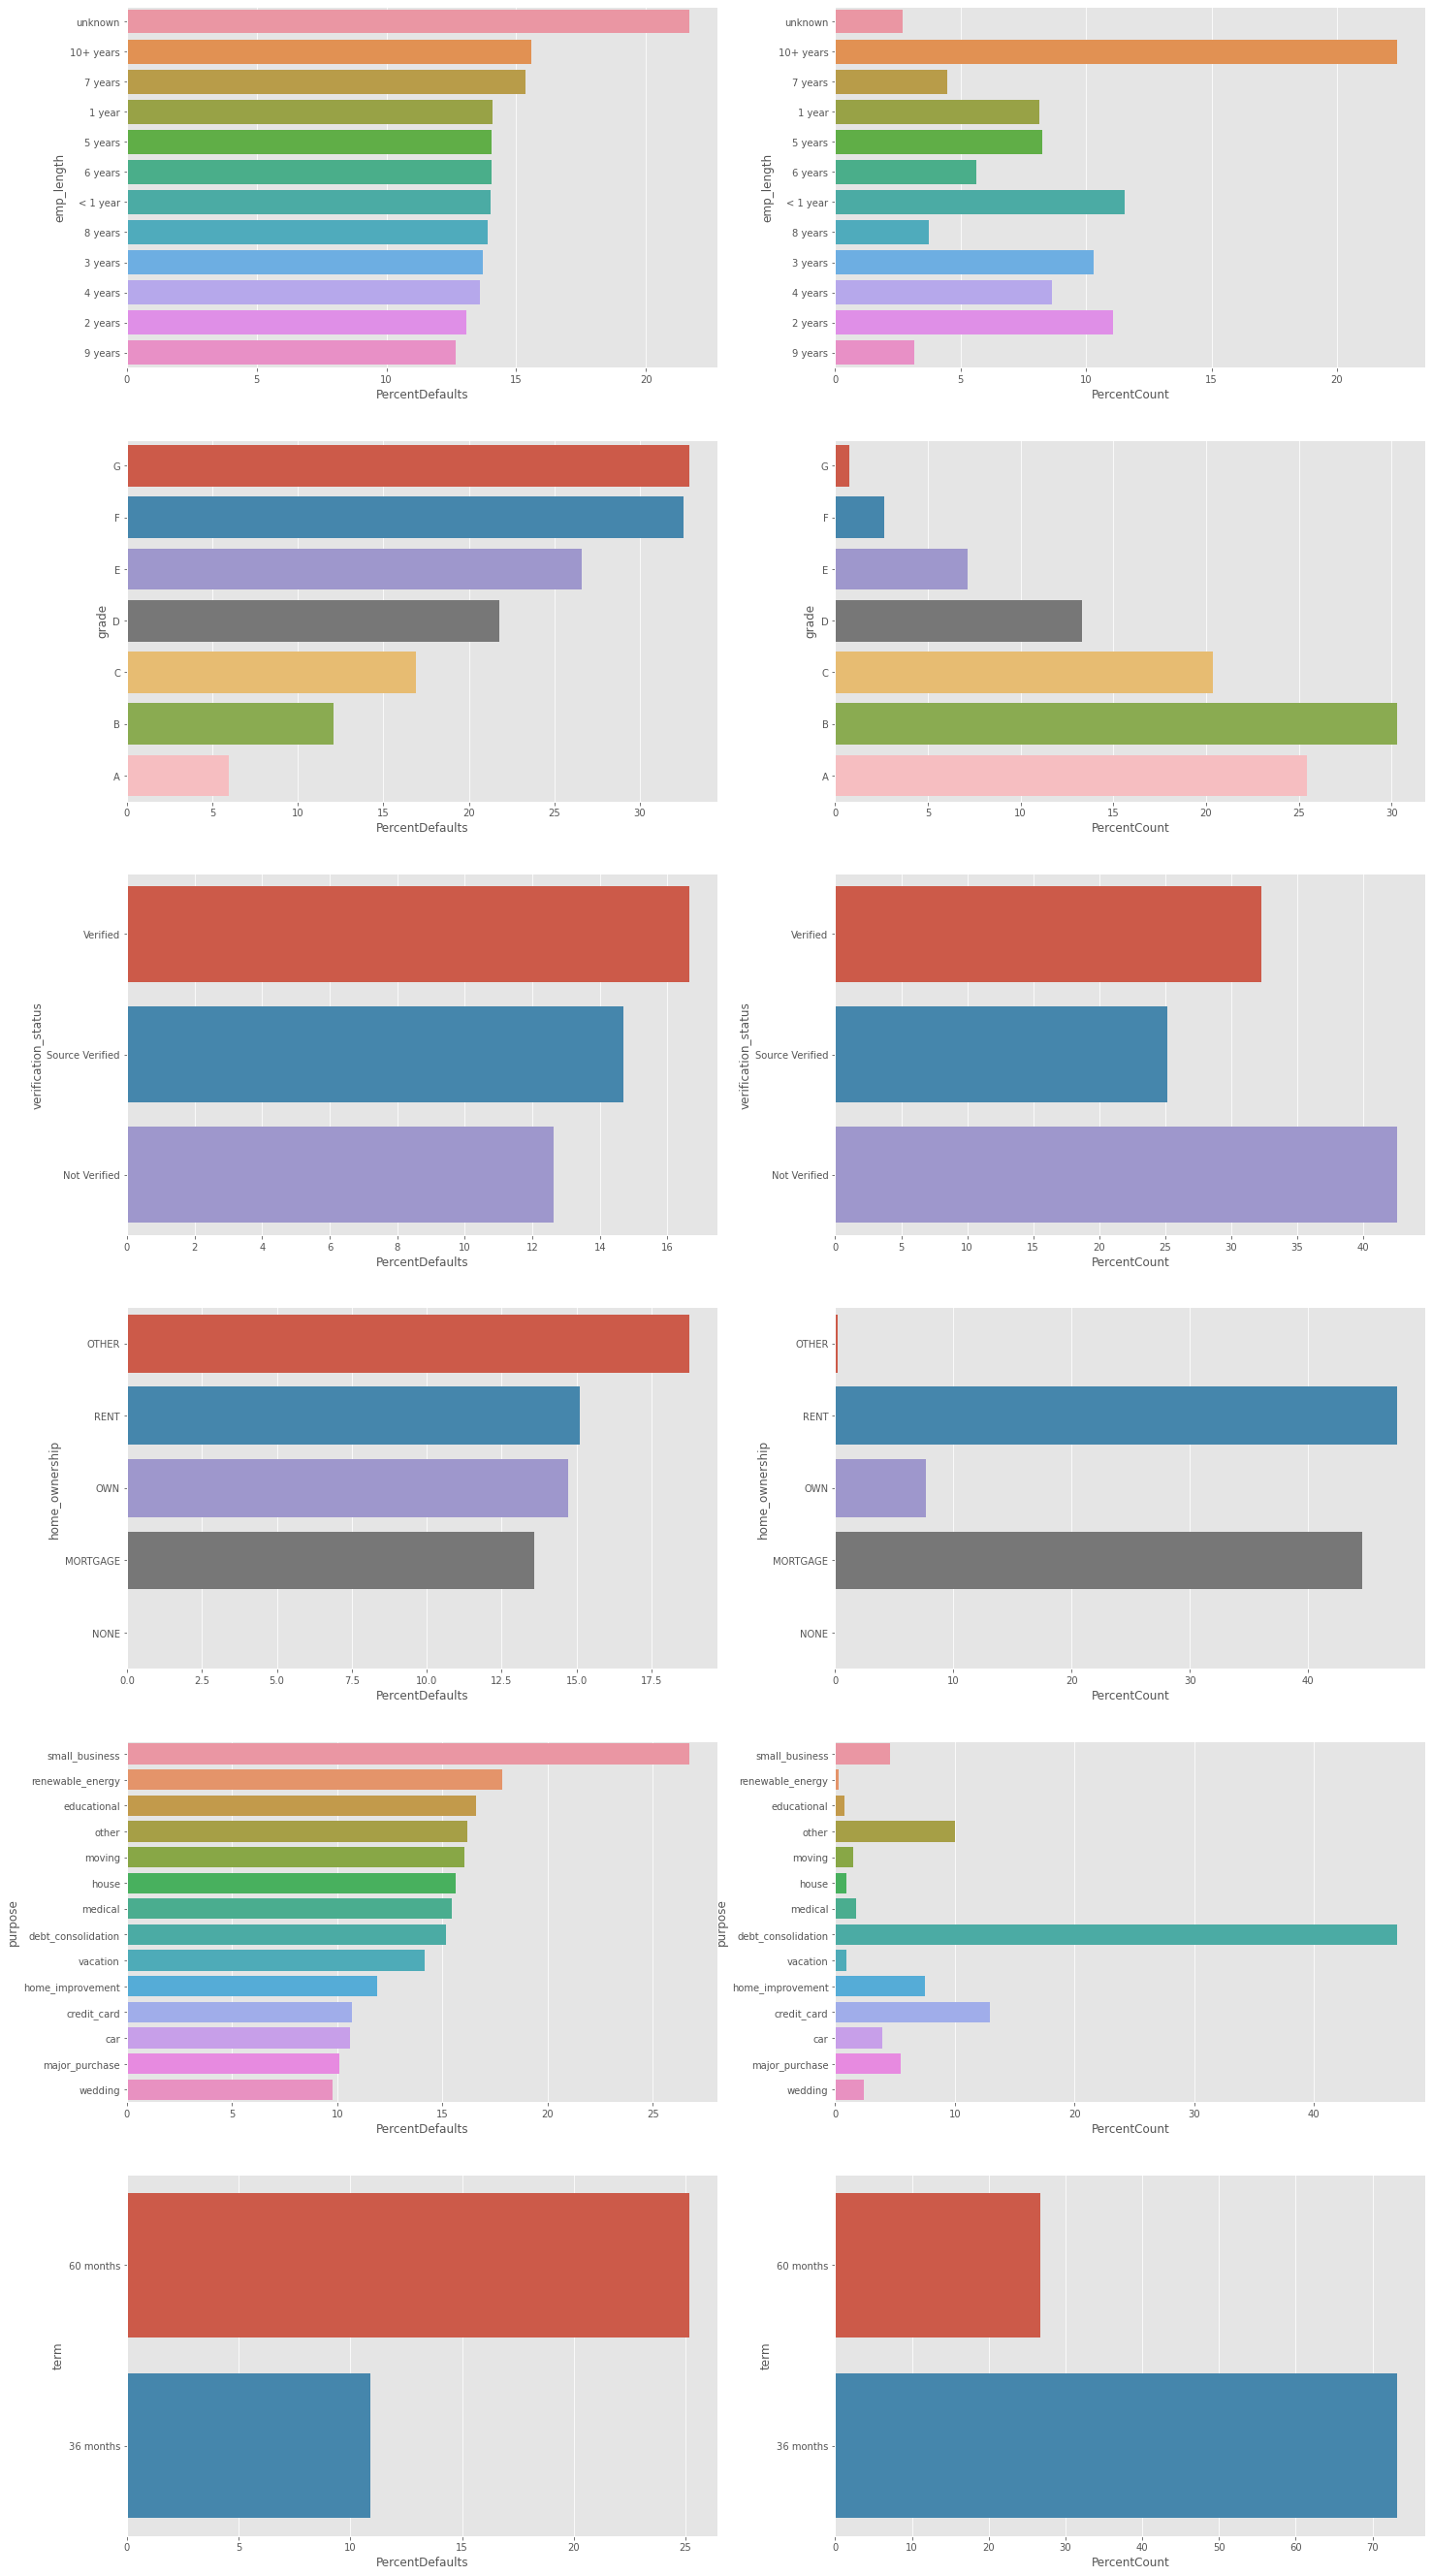

In [60]:
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(24, 48))
for i, col in enumerate(plot_cols): # 'pub_rec_bankruptcies', 
    df2 = pd.pivot_table(data=df1, index=col, 
                         columns=['loan_status'], aggfunc='count', 
                         fill_value=0).loan_amnt
    df2['PercentDefaults'] = \
        df2['Charged Off'] / (df2['Fully Paid'] + df2['Charged Off']) * 100
    df2['PercentCount'] = \
        ((df2['Charged Off'] + df2['Fully Paid'] + df2['Current']) / df1.shape[0] * 100)
    df2 = df2.sort_values('PercentDefaults', ascending=False)
    sns.barplot(data=df2, y=df2.index, x=df2.PercentDefaults, 
                ax=axes[i, 0])
    sns.barplot(data=df2, y=df2.index, x=df2.PercentCount, 
                ax=axes[i, 1])
plt.show()

#### Conclusion
- Better the Loan grade lower is the default percentage.
- Shorter loans have much smaller default rates.
- small business loans have the highest rate of defaults.
- Strangely, Verified loans have high default rates. This needs further investigation.
- If employment length is "unknown" the rate of default is high - needs further investigation.

### Convert annual income into a categorical
- Annual income is very skewed and hence difficult to analyse without dropping outliers.
- We convert it to a categorical with 6 levels

In [61]:
df1['annual_inc_class'] = pd.qcut(df1.annual_inc, q=[0, .05, .25, .5, .75, 0.95, 1.], 
                                  labels=[1, 2, 3, 4, 5, 6]
                                 ).astype(np.int64)
df1.annual_inc_class.value_counts()

4    9918
3    9901
5    7907
2    7729
1    2171
6    1972
Name: annual_inc_class, dtype: int64

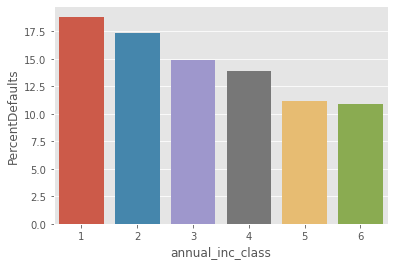

In [62]:
df2 = pd.pivot_table(data=df1, index='annual_inc_class', columns=['loan_status'], aggfunc='count').addr_state
df2['PercentDefaults'] = df2['Charged Off'] / (df2['Fully Paid'] + df2['Charged Off']) * 100
sns.barplot(df2.index, df2.PercentDefaults)
plt.show()

#### Observation
It is clearly seen that people with high annual incomes have lower default rates.

In [63]:
iqr = df1.annual_inc.quantile(0.75) - df1.annual_inc.quantile(0.25)
liqr = df1.annual_inc.quantile(0.25) - iqr * 1.5
uiqr = df1.annual_inc.quantile(0.75) + iqr * 1.5
df1.annual_inc[df1.annual_inc > uiqr].count() / df1.shape[0] * 100

4.651750088388303

#### 4.65% annual income are outliers  

### Analyse addr_state

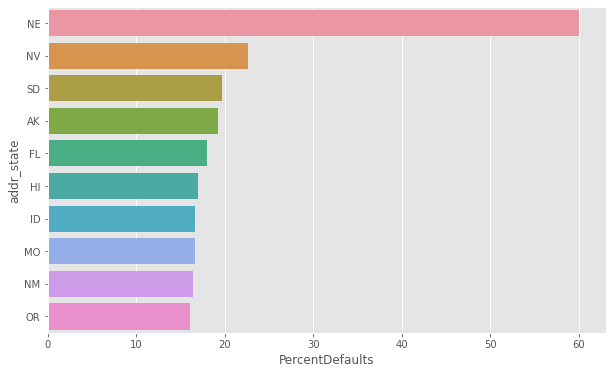

loan_status  Charged Off  Current  Fully Paid  PercentDefaults
addr_state                                                    
NE                     3        0           2        60.000000
NV                   108       18         370        22.594142
SD                    12        2          49        19.672131
AK                    15        2          63        19.230769
FL                   500       85        2277        18.005041
HI                    28        8         137        16.969697
ID                     1        0           5        16.666667
MO                   111       16         556        16.641679
NM                    30        6         153        16.393443
OR                    70       16         364        16.129032


In [64]:
# df1.addr_state.value_counts()
plt.figure(figsize=(10,6))
df2 = pd.pivot_table(data=df1, index='addr_state', columns=['loan_status'], aggfunc='count', fill_value=0).loan_amnt
df2['PercentDefaults'] = df2['Charged Off'] / (df2['Fully Paid'] + df2['Charged Off']) * 100
df2 = df2.sort_values('PercentDefaults', ascending=False)
df2 = df2.iloc[:10,:]
sns.barplot(y=df2.index, x=df2.PercentDefaults)
plt.show()
print(df2.head(10))

### Derived Metrics

#### Loan Amount as percentage of annual income

In [65]:
df1['amnt_to_income'] = df1.loan_amnt / (df1.annual_inc * 1000) *100 
df1['amnt_to_income'].describe()

count    39598.000000
mean        18.796157
std         11.632352
min          0.078947
25%         10.000000
50%         16.628283
75%         25.142857
max         83.000000
Name: amnt_to_income, dtype: float64

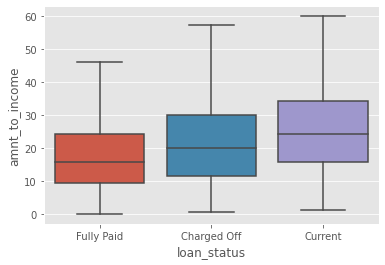

In [66]:
sns.boxplot(df1.loan_status, df1.amnt_to_income, showfliers=False)
plt.show()

In [67]:
# df1.groupby(['purpose', 'loan_status'])['int_rate'].count()

### Derived metrics from time based columns

#### difference in days between loan issue and earliest credit line

In [68]:
crline = (df1.issue_d - df1.earliest_cr_line).dt.days
crline = crline.astype(np.int64)
crline.describe()

count    39598.000000
mean      4959.241906
std       2711.925763
min     -21915.000000
25%       3318.000000
50%       4595.000000
75%       6209.000000
max      15615.000000
dtype: float64

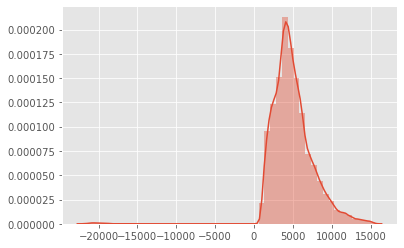

In [69]:
sns.distplot(crline)
plt.show()

#### difference in days beteen issue date and last credit pull

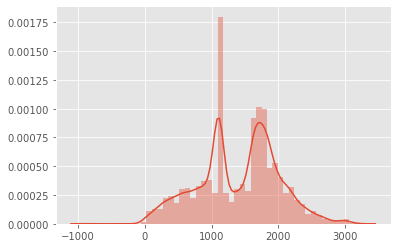

count    39598.000000
mean      1404.773019
std        600.660573
min       -884.000000
25%       1035.000000
50%       1492.000000
75%       1827.000000
max       3227.000000
dtype: float64


In [70]:
crpull = (df1.last_credit_pull_d - df1.issue_d).dt.days
crpull = crpull.astype(np.int64)
sns.distplot(crpull)
plt.show()
print(crpull.describe())

In [71]:
df1['cr_pull_days_after_issue'] = crpull
df1['cr_line_days_before_issue'] = crline
df1['cr_pull_days_class'] = pd.cut(df1.cr_pull_days_after_issue, 
    bins=[-884, 0, 1035, 1492, 1827, 3227])
df1['cr_line_days_class'] = pd.cut(df1.cr_line_days_before_issue, 
        bins=[-21915, 0, 3318, 4595, 6209, 15615], 
        )


#### See the effect of the above on defaults

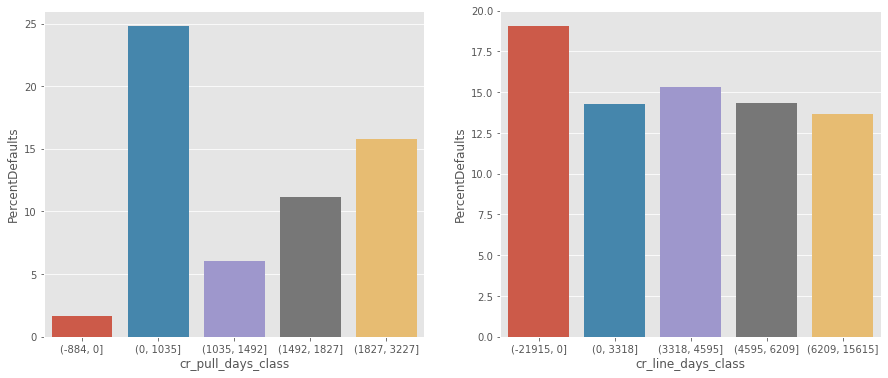

In [72]:
fig2, axes2 = plt.subplots(ncols = 2, figsize=(15, 6))
for i, col in enumerate(['cr_pull_days_class', 'cr_line_days_class']):  
    df2 = pd.pivot_table(data=df1, index=col, columns=['loan_status'], 
                         aggfunc='count', fill_value=0).loan_amnt
    df2['PercentDefaults'] = df2['Charged Off'] / (df2['Fully Paid'] + df2['Charged Off']) * 100
    sns.barplot(df2.index, df2.PercentDefaults, ax=axes2[i])
plt.show()

### See if month of loan issue has effect on defaults

In [73]:
df1['issue_m'] = df1.issue_d.dt.month

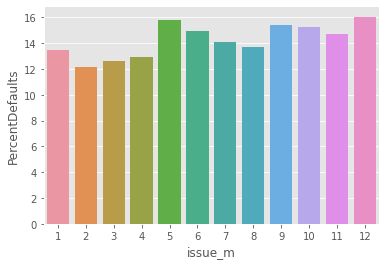

In [74]:
df2 = pd.pivot_table(data=df1, index='issue_m', columns=['loan_status'], aggfunc='count', fill_value=0).loan_amnt
df2['PercentDefaults'] = df2['Charged Off'] / (df2['Fully Paid'] + df2['Charged Off']) * 100
sns.barplot(df2.index, df2.PercentDefaults)
# plt.xticks(rotation=45)

#### Observations
- Issuing loans in the last 4 months leads to higher defaults
- Issuing loans in the first 4 months leads to lower defaults

## Bivariate Analysis

In [75]:
df1.shape

(39598, 39)

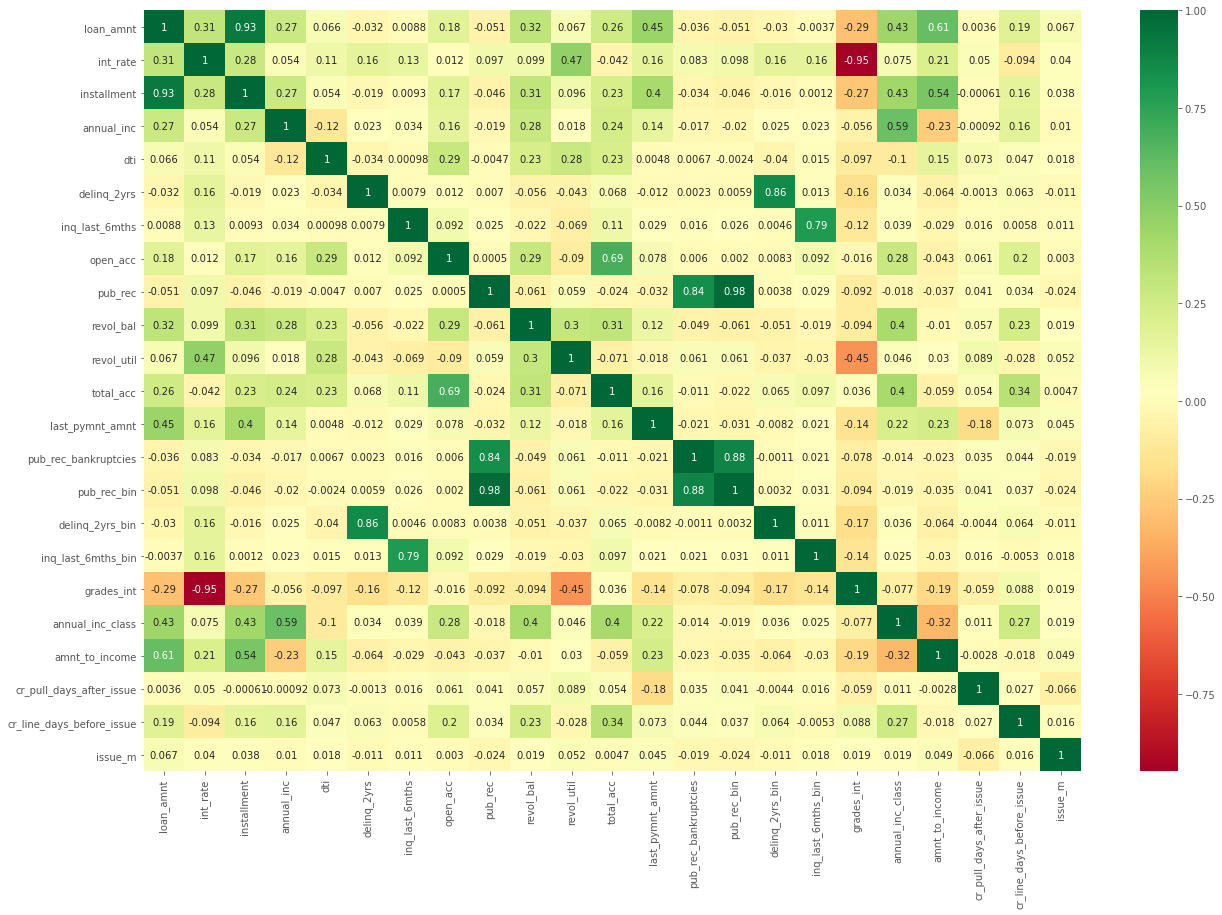

In [76]:
plt.figure(figsize=(21, 14))
dfcorr = df1.corr()
sns.heatmap(dfcorr, 
            xticklabels = dfcorr.columns.values,
            yticklabels = dfcorr.columns.values,
            annot = True, cmap="RdYlGn");
plt.show()

#### Observations
- pub_rec_bin and pub_rec_bankruptcies are highly correlated - can ignore one with lower number  of non-zero values 
- loan_amnt and installment are highly correlated - can ignore installment
- grades have high negative correlation with int_rate - Can ignore grade or int_rate

In [77]:
df1.pub_rec_bin.value_counts()

0    37491
1     2107
Name: pub_rec_bin, dtype: int64

In [78]:
df1.pub_rec_bankruptcies.value_counts()

0.0    37924
1.0     1667
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

### Based on the above we will consider the following main features to predict defaults
- annual_inc_class: Annual income
- loan_amnt: Amount of loan taken
- int_rate: Interest rate
- pub_rec_bin: Public derogatory records - yes/no
- pub_rec_bankruptcies: public bankruptcies 
- purpose: Why the loan was taken
- addr_state: State
- delinq_2yrs_bin: delinquencies in last 2 years
- inq_last_6mths_bin: inquiries in last 2 years
- term: length of loan

### See 2 factor effect on default rate
- Scatter plots are created
- income level is used as x axis
- y axis: 'pub_rec_bin', 'pub_rec_bankruptcies','purpose', 'delinq_2yrs_bin', 'inq_last_6mths_bin', 'term', grades_int', 'inq_last_6mths'
#### Size of the point in plot is amount of default

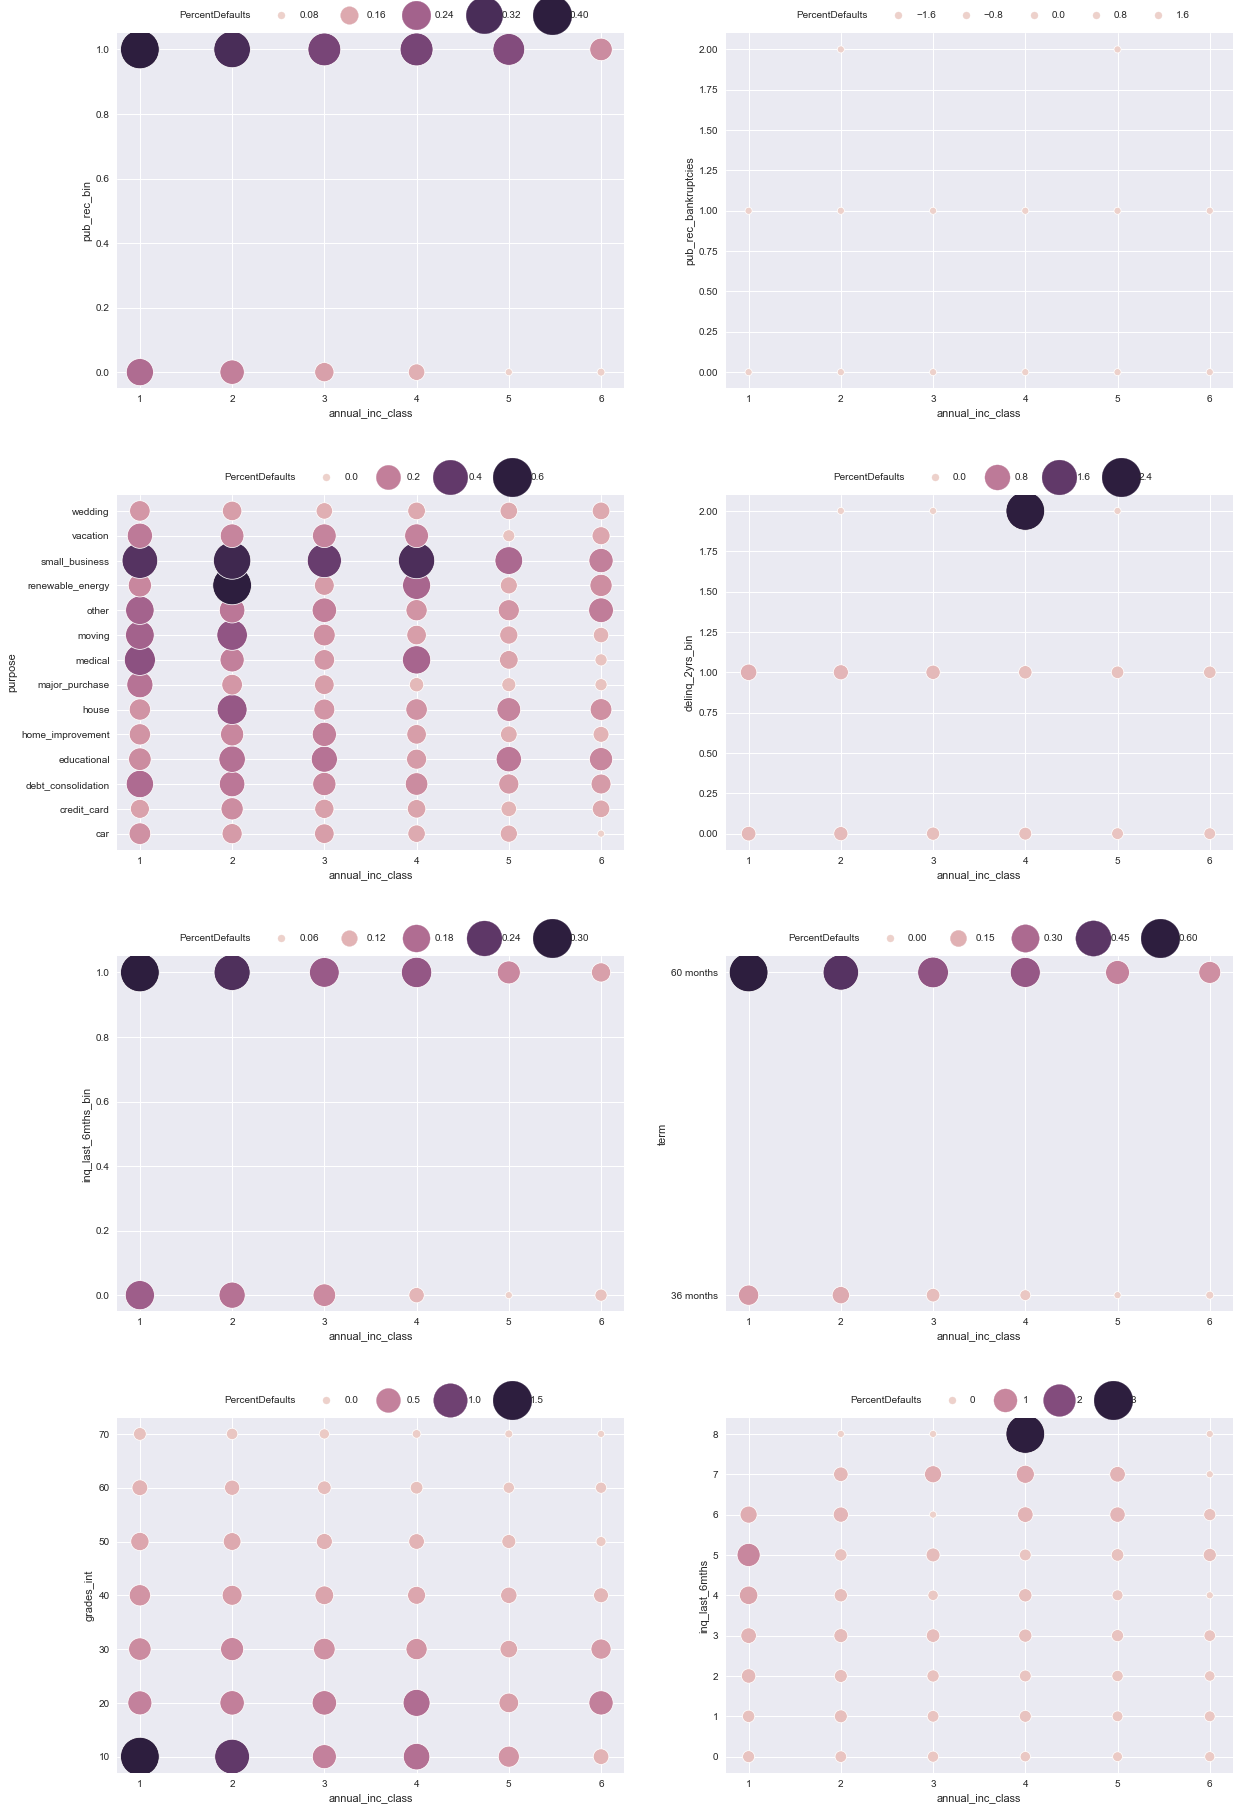

In [79]:
plt.style.use('seaborn')
fig, axes = plt.subplots(nrows=4, ncols = 2, figsize=(20, 32))
cols = ['pub_rec_bin', 'pub_rec_bankruptcies',
        'purpose', 'delinq_2yrs_bin', 'inq_last_6mths_bin', 'term', 'grades_int',
        'inq_last_6mths']
for i, c1 in enumerate(cols):        
    df2 = pd.pivot_table(data=df1, 
                         index=[c1, 'annual_inc_class'], 
                         columns=['loan_status'], 
                         aggfunc={'loan_status': 'count'}, 
                                  fill_value=0)
    df2.columns = df2.columns.droplevel(0)

    df2['PercentDefaults'] = df2['Charged Off'] / df2['Fully Paid']
    df2 = df2.reset_index()
    g = sns.scatterplot(data=df2, y=df2[c1], 
                    x=df2.annual_inc_class,
                    hue=df2.PercentDefaults, 
                    size=df2.PercentDefaults, 
                    sizes=(50, 1500), 
                   ax=axes[i // 2, i % 2])
    g.legend(loc='center', bbox_to_anchor=(.5,1.05 ), ncol=6)
plt.subplots_adjust(hspace = 0.3)
plt.show()


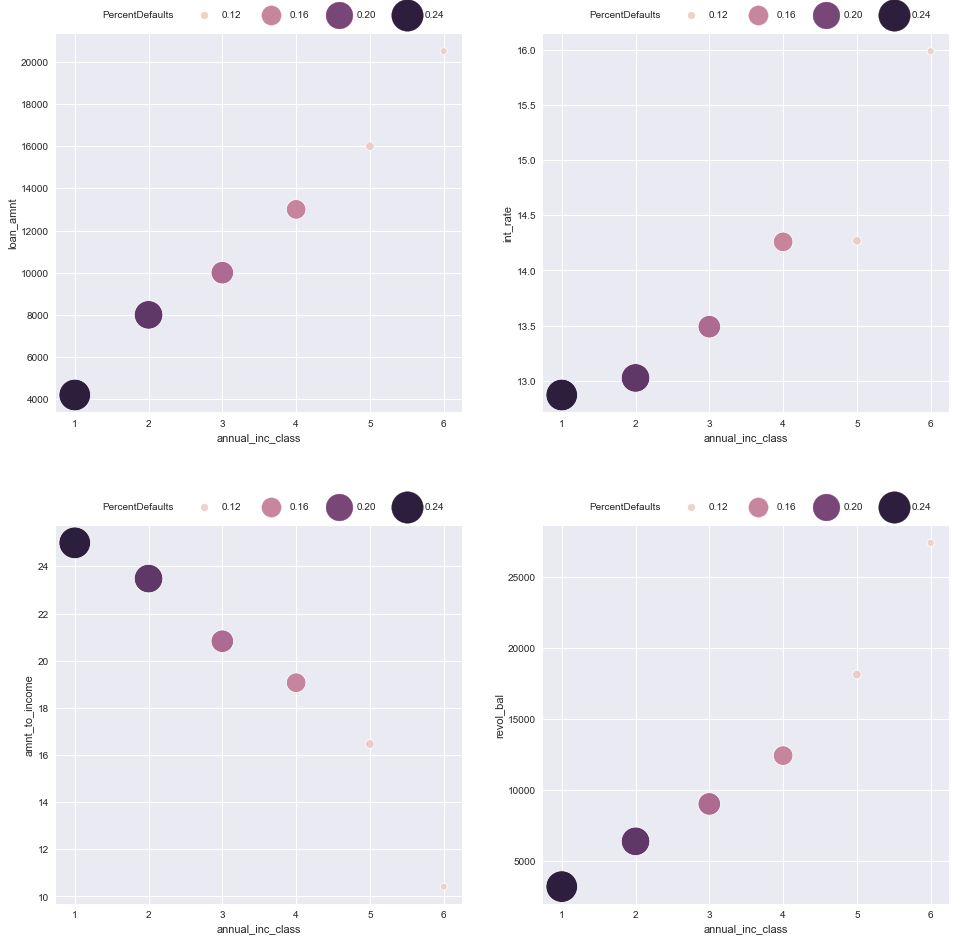

In [80]:
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize=(16, 16))
cols = ['loan_amnt', 'int_rate', 'amnt_to_income', 'revol_bal']
for i, c1 in enumerate(cols): 
    df2 = pd.pivot_table(data=df1, 
                     index=['annual_inc_class'], 
                     values=[c1],
                     columns=['loan_status'], 
                     aggfunc={c1: 'median', 'loan_status': 'count'}, 
                              fill_value=0)
    df2['PercentDefaults'] = df2['loan_status']['Charged Off'] / df2['loan_status']['Fully Paid']
    g = sns.scatterplot(data=df2, y=df2[c1]['Charged Off'], 
                x=df2.index, 
                hue=df2.PercentDefaults, 
                size=df2.PercentDefaults, sizes=(50, 1000),
                ax=axes[i//2, i%2])
    g.legend(loc='center', bbox_to_anchor=(.5,1.05 ), ncol=6)
    g.set(ylabel = c1)

plt.subplots_adjust(hspace = 0.3)
plt.show()

### The above analysis will be used to identify combinations that might lead to default

### The given data has 14.4% total defaults
### Try combinations which may result in higher defaults

In [81]:
def get_defaults(ls):
    return ls['Charged Off'] / (ls['Fully Paid'] + ls['Charged Off']) * 100
loan_status = df1.loan_status.value_counts()
print(get_defaults(loan_status))

14.4131260075927


In [82]:
df2 = df1[(df1.annual_inc_class < 3) & 
          (df1.int_rate > df1.int_rate.median()) & 
          (df1.pub_rec_bankruptcies > 0)
         ]
loan_status_2 = df2.loan_status.value_counts()
print(df2.shape, get_defaults(loan_status_2))

(252, 39) 31.275720164609055


In [83]:
df2 = df1[(df1.annual_inc_class < 3) & 
          (df1.int_rate > df1.int_rate.median()) & 
          (df1.purpose == 'small_business')
         ]
if df2.shape[0] > 0:
    vc = df2.loan_status.value_counts()
    print(df2.shape, get_defaults(vc))
else:
    print(df2.shape, 'No data')

(209, 39) 41.66666666666667


In [84]:
df2 = df1[(df1.annual_inc_class < 3) & 
          (df1.int_rate > df1.int_rate.median()) &
          (df1.term == '60 months') &
          (df1.purpose == 'small_business')
         ]
if df2.shape[0] > 0:
    vc = df2.loan_status.value_counts()
    print(df2.shape, get_defaults(vc))
else:
    print(df2.shape, 'No data')

(84, 39) 54.43037974683544


In [85]:
df2 = df1[(df1.annual_inc_class < 3) & 
          (df1.revol_bal > df1.revol_bal.median()) &
          (df1.purpose == 'small_business')
         ]
if df2.shape[0] > 0:
    vc = df2.loan_status.value_counts()
    print(df2.shape, get_defaults(vc))
else:
    print(df2.shape, 'No data')

(67, 39) 43.75


In [86]:
df2 = df1[(df1.annual_inc_class < 3) & 
          (df1.amnt_to_income > df1.amnt_to_income.median()) & 
          (df1.purpose == 'small_business')
         ]
if df2.shape[0] > 0:
    vc = df2.loan_status.value_counts()
    print(df2.shape, get_defaults(vc))
else:
    print(df2.shape, 'No data')

(272, 39) 33.45864661654135


In [87]:
df2 = df1[(df1.annual_inc_class < 3) & 
          (df1.amnt_to_income > df1.amnt_to_income.median()) &
          (df1.term == '60 months') &
          (df1.purpose.isin(['small_business']))
         ]
if df2.shape[0] > 0:
    vc = df2.loan_status.value_counts()
    print(df2.shape, get_defaults(vc))
else:
    print(df2.shape, 'No data')

(88, 39) 48.78048780487805


In [88]:
df2 = df1[(df1.annual_inc_class < 3) & 
          (df1.pub_rec_bin > 0) & 
          (df1.purpose.isin(['small_business']))
         ]
loan_status_2 = df2.loan_status.value_counts()
print(df2.shape, get_defaults(loan_status_2))

(30, 39) 26.666666666666668


In [89]:
df2 = df1[(df1.annual_inc_class < 3) 
          & (df1.amnt_to_income > df1.amnt_to_income.median())
          & (df1.addr_state.isin(['NE', 'NV', 'SD', 'AK', 'FL', 'MO', 'OR'])) 
          & (df1.purpose == 'small_business')
         ]
if df2.shape[0] > 0:
    vc = df2.loan_status.value_counts()
    print(df2.shape, get_defaults(vc))
else:
    print(df2.shape, 'No data')

(41, 39) 36.58536585365854


## Conclusion

### Features affecting defaults
|Factor|Description|Dangerous level|
|-------------|------------|-------------|
|annual_inc_class​|Annual income categorical– derived from annual_inc​|Under 25th percentile​|
|amnt_to_income​|Loan amount as % of annual income​|Above median​|
|loan_amnt​|Amount of loan taken​|Above Median​|
|int_rate​|Interest rate​|Above Median​|
|pub_rec_bin​|Public derogatory records - 0 or 1 – derived from pub_rec​|Above 0​|
|purpose​|Why the loan was taken​|Small_business, Other​|
|addr_state​|State​|'NE', 'NV', 'SD', 'AK', 'FL', 'MO', 'OR'​|
|delinq_2yrs_bin​|delinquencies in last 2 years – derived from delinq_2yrs​|Above 1​|
|inq_last_6mths_bin​|inquiries in last 2 years – derived from inq_last_6mths​|Above 0​|
|term​|Loan term​|60 months​|
  
### Combinations for high default rate
|Combination for default rate higher than 14.4%​||||Default rate​|
|------------|------------|------------|------------|------------|
|annual_inc_class < 25th percentile|​int_rate > median|small_business loan​||41.66%​|
|annual_inc_class < 25th percentile​|int_rate > median| ​ small_business loan| ​ term = 60 months​|54.43%​|
|annual_inc_class < 25th percentile ​| amnt_to_income > median | small_business loan|​  term = 60 months​|48.78%​|
|annual_inc_class < 25th percentile​ | revol_bal > median |​ small_business loan​||43.75%​|

### pairplot 
- THIS TAKES A LONG TIME TO RUN
- Hence commented out

In [90]:
# main_columns = ['loan_amnt', 'int_rate', 'annual_inc', 'annual_inc_class', 'pub_rec_bin', 'pub_rec_bankruptcies',
#                'purpose', 'addr_state', 'delinq_2yrs_bin', 'inq_last_6mths_bin', 'term', 'amnt_to_income', 'grade_int',
#                'inq_last_6mths', 'revol_bal']
# columns_not_considered = list(set(df1.columns) - set(main_columns))
# dfpair = df1.drop(columns_not_considered, axis=1)
# sns.pairplot(dfpair)
# plt.show()

## This finishes all analysis
---

# Rough Work
- Kept for my own future reference

In [91]:
# dd = df1.groupby(['annual_inc_class', 'term', 'loan_status']).count()
# dd.reset_index(inplace=True)
# dd

In [92]:
df1.loan_amnt[(df1.loan_amnt < df1.loan_amnt.mean() + df1.loan_amnt.std() * 3)].count() / df1.shape[0] * 100

98.18677710995505

In [93]:
delinq = df1.delinq_2yrs_bin.apply(lambda x: 1 if x == 0 else x+1)
bkr = df1.pub_rec_bankruptcies.apply(lambda x: 1 if x == 0 else x+1)
df1['amnt_to_income_adj'] = df1['amnt_to_income'] * delinq * bkr
df1['amnt_to_income_adj'].describe()

count    39598.000000
mean        21.423351
std         15.058868
min          0.078947
25%         10.736711
50%         18.065063
75%         28.361848
max        217.250000
Name: amnt_to_income_adj, dtype: float64

In [94]:
# derive metric from emp length
import re
def mod_year(x):
    x = re.sub('\s+year[s]?$', '', x)
    x = re.sub('unknown', '-1', x)
    x = re.sub('^<\s+1', '0', x)
    x = re.sub('10\+', '10', x)
    return int(x)
    
emp_years = df.emp_length.apply(mod_year)
df1['emp_class'] = emp_years.apply(lambda x: 'short' if x < 9 else 'long')
df1.emp_class.value_counts()

short    29474
long     10124
Name: emp_class, dtype: int64

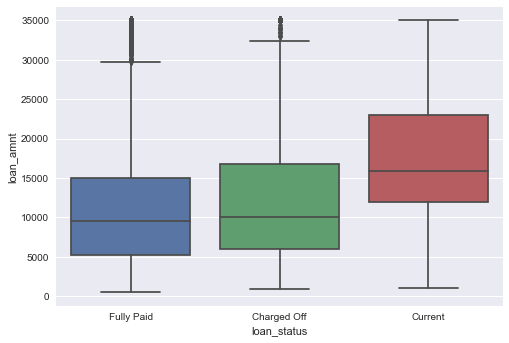

In [95]:
# df2 = df1[(df1.loan_amnt < df1.loan_amnt.mean() + df1.loan_amnt.std() * 2.5)]
sns.boxplot(df1.loan_status, df1.loan_amnt)
plt.show()

In [96]:
df1.loan_status.value_counts()

Fully Paid     32915
Charged Off     5543
Current         1140
Name: loan_status, dtype: int64

In [97]:
df.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64